In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import split_scale
import features

#### Acquire and summarize data

In [97]:
#data for baseline model
df = wrangle.wrangle_zillow()

In [ ]:
#data for tax rate distribution
df_tax = wrangle.zillow_tax()


In [34]:
#tax_value in thousands
df.tax_value = df.tax_value /1000


In [65]:
#df['percentile_rank'] = df.tax_value.rank(pct=True)
#df['bedroom_per_sqft'] = df.sqft / df.bedrooms
#df.sort_values(by='bedroom_per_sqft',ascending=False)
#df_all = df
#sns.boxplot(x=df.bedroom_per_sqft)
df = df[df.bedroom_per_sqft<1000]


,bathrooms,bedrooms,sqft,tax_value,percentile_rank,bedroom_per_sqft
0,2.0,4.0,1604.0,498.347,0.745818,401.000000
1,3.0,3.0,2384.0,549.917,0.786956,794.666667
2,2.0,3.0,1574.0,235.272,0.363991,524.666667
3,2.0,2.0,1619.0,340.000,0.546573,809.500000
5,2.0,4.0,1721.0,629.951,0.837141,430.250000
6,1.0,3.0,1136.0,305.481,0.492124,378.666667
7,1.0,2.0,1088.0,79.930,0.093797,544.000000
8,1.0,2.0,914.0,260.000,0.412777,457.000000
9,2.0,3.0,1263.0,66.220,0.063659,421.000000
10,1.0,3.0,1330.0,595.000,0.818134,443.333333


In [99]:
#running MVP model by county, LA = 6037, Orange = 6059, Ventura = 6111
df = df[df.fips==6059]
df.describe()

,zipcode,fips,id,bathrooms,bedrooms,sqft,tax_value
count,2781.000000,2783.0,2783.000000,2783.000000,2783.000000,2783.000000,2.783000e+03
mean,96920.104639,6059.0,41516.020122,2.460834,3.496946,2074.432627,5.485106e+05
std,247.525190,0.0,1545.519409,0.947722,0.887189,1109.422660,7.092845e+05
min,96180.000000,6059.0,10790.000000,1.000000,1.000000,388.000000,1.611900e+04
25%,96964.000000,6059.0,40745.500000,2.000000,3.000000,1414.500000,2.463495e+05
50%,96990.000000,6059.0,41461.000000,2.500000,3.000000,1852.000000,4.092250e+05
75%,97024.000000,6059.0,42173.500000,3.000000,4.000000,2467.000000,6.489820e+05
max,97079.000000,6059.0,44867.000000,19.500000,10.000000,26345.000000,1.168967e+07


In [67]:
df_tax.head(1)
df_tax['county']=df_tax['fips']
df_tax.county.min()

NameError: name 'df_tax' is not defined

In [ ]:
#acquiring county names based on fips field
#from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

In [ ]:
df_tax.head(2)

In [ ]:
df_tax.describe()

#### Tax distribution

In [84]:
#Tax distribution by county.

from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.1)
plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

NameError: name 'df_tax' is not defined

In [ ]:
df.describe()

In [87]:
df.dtypes

zipcode            float64
fips               float64
transactiondate     object
id                   int64
bathrooms          float64
bedrooms           float64
sqft               float64
tax_value          float64
dtype: object

In [ ]:
sns.distplot(df['bedrooms'])

In [ ]:
sns.distplot(df['bathrooms'])

In [ ]:
sns.distplot(df['sqft'])
plt.xlim(0,10000)

In [ ]:
sns.distplot(df['tax_value'])
plt.xlim(0,1_000_000)

#### Prep and clean data

In [100]:
#dropping id and transactiondate from table before scaling
df.drop('id',axis=1,inplace=True)
df.drop('transactiondate',axis=1,inplace=True)
df.drop('fips',axis=1,inplace=True)


In [101]:
df.drop('bedrooms',axis=1,inplace=True)

In [102]:
df.drop('zipcode',axis=1,inplace=True)

In [108]:
df.drop('bathrooms',axis=1,inplace=True)

#### Split and Scale

In [110]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123)

In [104]:
#scaler, train, test = split_scale.standard_scaler(train,test)
#train.drop('bedroom_per_sqft',axis=1,inplace=True)


KeyError: "['bedroom_per_sqft'] not found in axis"

In [111]:
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

In [112]:
train.head()

,sqft,tax_value
7234,2379.0,854315.0
8619,1893.0,266739.0
7501,976.0,297254.0
7268,1363.0,61737.0
8935,1938.0,688000.0


#### Data exploration

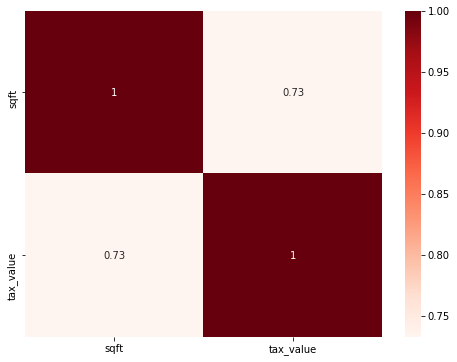

In [113]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [114]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [115]:
#r2 of 
r2_lm1 = r2_score(y_train,train.yhat)
r2_lm1

0.5365191403521223

In [116]:
#creating baseline with mean of tax value
train['tax_mean'] = train.tax_value.mean()
train.head()

,sqft,tax_value,yhat,tax_mean
7234,2379.0,854315.0,690471.335120,547600.467655
8619,1893.0,266739.0,466836.367661,547600.467655
7501,976.0,297254.0,44874.916715,547600.467655
7268,1363.0,61737.0,222954.613025,547600.467655
8935,1938.0,688000.0,487543.309092,547600.467655


In [117]:
#creating residual of tax value vs expected tax value
train['residual'] = train['yhat'] - train['tax_value']
train['residual2'] = train.residual **2

In [118]:
train.head(1)

,sqft,tax_value,yhat,tax_mean,residual,residual2
7234,2379.0,854315.0,690471.33512,547600.467655,-163843.66488,2.684475e+10


#### Modeling & Evaluation MVP

In [119]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm1 = LinearRegression()


In [122]:
#fit and train model
lm1.fit(X_train,y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_

#print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
#print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

    y-intercept  (b): -404235.64
    coefficient (m1): 460.15


In [123]:
#converting y_train to panda series
y_train = y_train.tax_value

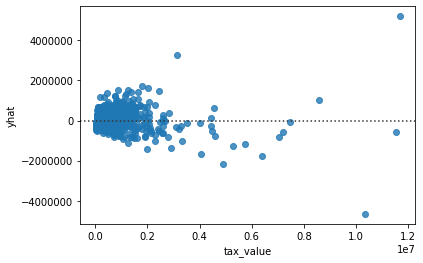

In [124]:
#Plotting residuals
sns.residplot(y_train,train.yhat)

In [125]:
#MSE, SSE, RMSE
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

525066292412340.3 235878837561.69824 485673.5915835843 0.5365191403521226


Text(0.5, 1, 'Predicted vs Actual Tax Value')

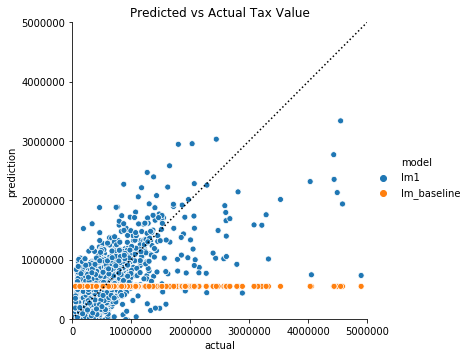

In [126]:
pd.DataFrame({'actual': y_train,
              'lm1': train.yhat,
              'lm_baseline': train.tax_mean})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [127]:
mse_lm1 = mean_squared_error(y_train,train.tax_mean)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 


#print('  {:.2%} of the variance in the house price can be explained by the num of bathrooms, num of bedrooms, and sq ft of house.'.format(r2_lm1))

linear model
  mean squared error: 5.09e+11
